In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
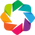

Loading BokehJS ...

Loading BokehJS ...

In [3]:
from ast import literal_eval
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from matplotlib.colors import LinearSegmentedColormap, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# for html to png
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options

from SSMuLA.landscape_global import LIB_INFO_DICT
from SSMuLA.de_simulations import DE_TYPES
from SSMuLA.zs_analysis import ZS_OPTS, ZS_COMB_OPTS
from SSMuLA.vis_summary import ZS_METRICS
from SSMuLA.get_corr import LANDSCAPE_ATTRIBUTES, val_list, zs_list
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, save_plt
from SSMuLA.util import checkNgen_folder


import os
from glob import glob
from tqdm import tqdm

import pandas as pd
import numpy as np

from ast import literal_eval

from scipy.stats import spearmanr

import bokeh
from bokeh.io import show, export_svg, export_png, output_notebook
from bokeh.plotting import show, figure
from bokeh.themes.theme import Theme


import holoviews as hv
from holoviews import opts, dim

from SSMuLA.landscape_global import get_file_name, n_mut_cutoff_dict
from SSMuLA.de_simulations import DE_TYPES
from SSMuLA.zs_analysis import ZS_OPTS, ZS_COMB_OPTS, ZS_OPTS_LEGEND
from SSMuLA.vis_summary import N_SAMPLE_LIST, N_MUT_SUBS, ZS_METRICS, ZS_N_MUTS
from SSMuLA.vis import LIB_COLORS, save_bokeh_hv
from SSMuLA.util import checkNgen_folder



# Custom colormap for the MSE row, using greens
cmap_mse = LinearSegmentedColormap.from_list(
    "mse_cmap_r", ["#FFFFFF", "#9bbb59"][::-1], N=100
)  # dark to light green

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(
    "bwg",
    [
        PRESENTATION_PALETTE_SATURATE["blue"],
        "white",
        PRESENTATION_PALETTE_SATURATE["green"],
    ],
    N=100,
)

custom_cmap_r = LinearSegmentedColormap.from_list(
    "bwg_r",
    [
        sns.dark_palette("seagreen").as_hex()[-1],
        "white",
        sns.color_palette("Blues").as_hex()[-1],
    ],
    N=100,
)

de_metrics = ["mean_all", "fraction_max"]

simple_des = {
    "recomb_SSM": "Recomb",
    "single_step_DE": "Single step",
    "top96_SSM": "Top96 recomb",
}

In [4]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]

In [5]:
zs_csv = "results/zs_sum_2/min0/zs_stat_scale2max.csv"

In [6]:
zs_df = pd.read_csv(zs_csv)
n_mut = "all"

zs_df_list = [zs_df[["lib", "n_mut"]]]
# Create new columns for each score type
# for c in ZS_OPTS + ZS_COMB_OPTS:
for c in ZS_OPTS:
    zs_name = c.replace("_score", "")
    zs_df_list.append(
        zs_df[f"{zs_name}_score"]
        .str.replace(": nan", ": None")
        .apply(literal_eval)
        .apply(pd.Series)
        .rename(columns={m: f"{zs_name}_{m}" for m in ZS_METRICS})
    )

zs_df_expend = pd.concat(zs_df_list, axis=1)

zs_mut_df_list = [zs_df_expend[zs_df_expend["n_mut"] == n_mut]["lib"]]
for n_mut in ZS_N_MUTS:
    slice_df = (
        zs_df_expend[zs_df_expend["n_mut"] == n_mut]
        .drop(columns=["lib", "n_mut"])
        .reset_index(drop=True)
    )
    zs_mut_df_list.append(
        slice_df.rename(columns={c: f"{n_mut}_{c}" for c in slice_df.columns})
    )
zs_df = pd.concat(zs_mut_df_list, axis=1)
zs_df

,lib,all_ed_rho,all_ed_ndcg,all_ed_rocauc,all_Triad_rho,all_Triad_ndcg,all_Triad_rocauc,all_ev_rho,all_ev_ndcg,all_ev_rocauc,...,single_Triad_rocauc,single_ev_rho,single_ev_ndcg,single_ev_rocauc,single_esm_rho,single_esm_ndcg,single_esm_rocauc,single_esmif_rho,single_esmif_ndcg,single_esmif_rocauc
0,DHFR,0.251154,0.914803,0.719973,0.017801,0.874707,0.452238,0.339650,0.947058,0.912765,...,0.268056,0.539415,0.903888,0.858333,0.601895,0.888069,0.972222,0.543880,0.891263,0.901389
1,GB1,0.144928,0.687396,0.577572,0.288282,0.764049,0.715632,0.189509,0.721558,0.627690,...,0.914313,0.206331,0.661881,0.564030,0.440586,0.704043,0.698682,0.789395,0.813024,0.903013
2,ParD2,0.297520,0.902898,0.552103,0.227370,0.843746,0.652049,0.440248,0.915307,0.664011,...,0.964912,0.559137,0.958934,0.842105,0.726660,0.986325,0.929825,0.610692,0.978150,0.964912
3,ParD3,0.456627,0.953525,0.564976,0.284501,0.886169,0.906254,0.460576,0.955882,0.705520,...,NaN,0.285552,0.993109,NaN,0.418438,0.995192,NaN,0.343751,0.995486,NaN
4,TrpB3A,0.146519,0.672480,0.608694,-0.016552,0.488693,0.664616,0.105892,0.743685,0.657328,...,0.599537,0.509671,0.896221,0.910880,0.376806,0.815387,0.780093,0.480566,0.902487,0.837963
5,TrpB3B,0.048451,0.638318,0.551217,0.041425,0.348852,0.653659,0.056590,0.672504,0.583225,...,0.734568,0.360187,0.861174,0.876543,0.277389,0.930933,0.956790,0.356783,0.987106,1.000000
6,TrpB3C,0.055999,0.646208,0.605496,0.043581,0.680187,0.621564,0.050793,0.660263,0.539872,...,0.969697,0.222355,0.833494,0.963636,0.313306,0.908899,0.987879,0.388312,0.905966,0.987879
7,TrpB3D,0.119253,0.750375,0.609910,0.213946,0.761741,0.751696,0.233182,0.822937,0.785684,...,0.682382,0.461335,0.863870,0.733251,0.435387,0.884522,0.666253,0.270137,0.824320,0.615385
8,TrpB3E,0.013191,0.728204,0.563633,-0.017332,0.593711,0.504706,0.017571,0.852058,0.515337,...,0.279770,0.728321,0.969119,0.979914,0.688940,0.913281,0.981349,0.479928,0.746702,0.829268
9,TrpB3F,0.209446,0.763770,0.865507,0.093448,0.688977,0.865511,0.103260,0.804297,0.873863,...,0.676179,0.442103,0.866942,0.604218,0.364750,0.861646,0.622829,0.305374,0.842523,0.624069


In [7]:
active_lib_list = ['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [8]:
zs_df["type"] = zs_df["lib"].map(
    {n: v["type"] for n, v in LIB_INFO_DICT.items()}
)
zs_df

,lib,all_ed_rho,all_ed_ndcg,all_ed_rocauc,all_Triad_rho,all_Triad_ndcg,all_Triad_rocauc,all_ev_rho,all_ev_ndcg,all_ev_rocauc,...,single_ev_rho,single_ev_ndcg,single_ev_rocauc,single_esm_rho,single_esm_ndcg,single_esm_rocauc,single_esmif_rho,single_esmif_ndcg,single_esmif_rocauc,type
0,DHFR,0.251154,0.914803,0.719973,0.017801,0.874707,0.452238,0.339650,0.947058,0.912765,...,0.539415,0.903888,0.858333,0.601895,0.888069,0.972222,0.543880,0.891263,0.901389,Enzymatic activity
1,GB1,0.144928,0.687396,0.577572,0.288282,0.764049,0.715632,0.189509,0.721558,0.627690,...,0.206331,0.661881,0.564030,0.440586,0.704043,0.698682,0.789395,0.813024,0.903013,Binding
2,ParD2,0.297520,0.902898,0.552103,0.227370,0.843746,0.652049,0.440248,0.915307,0.664011,...,0.559137,0.958934,0.842105,0.726660,0.986325,0.929825,0.610692,0.978150,0.964912,Binding
3,ParD3,0.456627,0.953525,0.564976,0.284501,0.886169,0.906254,0.460576,0.955882,0.705520,...,0.285552,0.993109,NaN,0.418438,0.995192,NaN,0.343751,0.995486,NaN,Binding
4,TrpB3A,0.146519,0.672480,0.608694,-0.016552,0.488693,0.664616,0.105892,0.743685,0.657328,...,0.509671,0.896221,0.910880,0.376806,0.815387,0.780093,0.480566,0.902487,0.837963,Enzymatic activity
5,TrpB3B,0.048451,0.638318,0.551217,0.041425,0.348852,0.653659,0.056590,0.672504,0.583225,...,0.360187,0.861174,0.876543,0.277389,0.930933,0.956790,0.356783,0.987106,1.000000,Enzymatic activity
6,TrpB3C,0.055999,0.646208,0.605496,0.043581,0.680187,0.621564,0.050793,0.660263,0.539872,...,0.222355,0.833494,0.963636,0.313306,0.908899,0.987879,0.388312,0.905966,0.987879,Enzymatic activity
7,TrpB3D,0.119253,0.750375,0.609910,0.213946,0.761741,0.751696,0.233182,0.822937,0.785684,...,0.461335,0.863870,0.733251,0.435387,0.884522,0.666253,0.270137,0.824320,0.615385,Enzymatic activity
8,TrpB3E,0.013191,0.728204,0.563633,-0.017332,0.593711,0.504706,0.017571,0.852058,0.515337,...,0.728321,0.969119,0.979914,0.688940,0.913281,0.981349,0.479928,0.746702,0.829268,Enzymatic activity
9,TrpB3F,0.209446,0.763770,0.865507,0.093448,0.688977,0.865511,0.103260,0.804297,0.873863,...,0.442103,0.866942,0.604218,0.364750,0.861646,0.622829,0.305374,0.842523,0.624069,Enzymatic activity


In [9]:
slice_zs = zs_df[zs_df["lib"].isin(active_lib_list)]
zs_cols = ["all_" + zs.replace("score", "rho") for zs in ZS_OPTS]
zs_rocauc_cols = ["all_" + zs.replace("score", "rocauc") for zs in ZS_OPTS]

In [10]:
binding = slice_zs[slice_zs["type"] == "Binding"]
ea = slice_zs[slice_zs["type"] == "Enzymatic activity"]

In [11]:
slice_zs[zs_cols].mean(axis=0), binding[zs_cols].mean(axis=0), ea[zs_cols].mean(axis=0)

(all_ed_rho       0.190650
 all_Triad_rho    0.160620
 all_ev_rho       0.257969
 all_esm_rho      0.257452
 all_esmif_rho    0.259739
 dtype: float64,
 all_ed_rho       0.299692
 all_Triad_rho    0.266718
 all_ev_rho       0.363444
 all_esm_rho      0.390565
 all_esmif_rho    0.480481
 dtype: float64,
 all_ed_rho       0.143918
 all_Triad_rho    0.115150
 all_ev_rho       0.212765
 all_esm_rho      0.200403
 all_esmif_rho    0.165136
 dtype: float64)

In [12]:
slice_zs[zs_rocauc_cols].mean(axis=0), binding[zs_rocauc_cols].mean(axis=0), ea[zs_rocauc_cols].mean(axis=0)

(all_ed_rocauc       0.636173
 all_Triad_rocauc    0.707701
 all_ev_rocauc       0.756567
 all_esm_rocauc      0.737771
 all_esmif_rocauc    0.773699
 dtype: float64,
 all_ed_rocauc       0.564884
 all_Triad_rocauc    0.757978
 all_ev_rocauc       0.665740
 all_esm_rocauc      0.671912
 all_esmif_rocauc    0.785210
 dtype: float64,
 all_ed_rocauc       0.666725
 all_Triad_rocauc    0.686154
 all_ev_rocauc       0.795493
 all_esm_rocauc      0.765996
 all_esmif_rocauc    0.768766
 dtype: float64)

In [13]:
for n in N_SAMPLE_LIST:
    merge_csv = f"results/corr_all/{str(n)}/boosting|ridge-top96/actcut-1/merge_all.csv"
    merge_df = pd.read_csv(merge_csv)
    

In [14]:
%matplotlib inline

In [15]:
from SSMuLA.landscape_global import LIB_TYPES

In [16]:
from SSMuLA.zs_analysis import ZS_OPTS_LEGEND

In [17]:
from matplotlib.lines import Line2D

In [18]:
# get msa factors
from SSMuLA.zs_data import EV_META

In [19]:
EV_META.keys()

dict_keys(['DHFR', 'ParD2', 'ParD3', 'GB1', 'TrpB'])

In [20]:
get_msa_dict = {}

for l, v in EV_META.items():
    if l != "TrpB":
        if "chosen" in v.keys():
            get_msa_dict[l] = v["chosen"]["sequences"]
        else:
            get_msa_dict[l] = v["recommended"]["sequences"]
    else:
        ls = [l+ "3"+ app for app in [chr(i) for i in range(ord('A'), ord('I')+1)]]+ ["TrpB4"]
        for t in ls:
            if "chosen" in v.keys():
                get_msa_dict[t] = v["chosen"]["sequences"]
            else:
                get_msa_dict[t] = v["recommended"]["sequences"]

In [21]:
get_msa_dict

{'DHFR': 16042,
 'ParD2': 6789,
 'ParD3': 6784,
 'GB1': 29,
 'TrpB3A': 5816,
 'TrpB3B': 5816,
 'TrpB3C': 5816,
 'TrpB3D': 5816,
 'TrpB3E': 5816,
 'TrpB3F': 5816,
 'TrpB3G': 5816,
 'TrpB3H': 5816,
 'TrpB3I': 5816,
 'TrpB4': 5816}

In [22]:
msa_df = pd.DataFrame(get_msa_dict, index=["MSA"]).T.reset_index()
msa_df.columns=["lib", "msa"]
msa_df

,lib,msa
0,DHFR,16042
1,ParD2,6789
2,ParD3,6784
3,GB1,29
4,TrpB3A,5816
5,TrpB3B,5816
6,TrpB3C,5816
7,TrpB3D,5816
8,TrpB3E,5816
9,TrpB3F,5816


In [23]:
zs_append_msa = pd.merge(zs_df, msa_df, on="lib")
slice_zs_msa = zs_append_msa[zs_append_msa["lib"].isin(active_lib_list)]
slice_zs_msa

,lib,all_ed_rho,all_ed_ndcg,all_ed_rocauc,all_Triad_rho,all_Triad_ndcg,all_Triad_rocauc,all_ev_rho,all_ev_ndcg,all_ev_rocauc,...,single_ev_ndcg,single_ev_rocauc,single_esm_rho,single_esm_ndcg,single_esm_rocauc,single_esmif_rho,single_esmif_ndcg,single_esmif_rocauc,type,msa
0,DHFR,0.251154,0.914803,0.719973,0.017801,0.874707,0.452238,0.339650,0.947058,0.912765,...,0.903888,0.858333,0.601895,0.888069,0.972222,0.543880,0.891263,0.901389,Enzymatic activity,16042
1,GB1,0.144928,0.687396,0.577572,0.288282,0.764049,0.715632,0.189509,0.721558,0.627690,...,0.661881,0.564030,0.440586,0.704043,0.698682,0.789395,0.813024,0.903013,Binding,29
2,ParD2,0.297520,0.902898,0.552103,0.227370,0.843746,0.652049,0.440248,0.915307,0.664011,...,0.958934,0.842105,0.726660,0.986325,0.929825,0.610692,0.978150,0.964912,Binding,6789
3,ParD3,0.456627,0.953525,0.564976,0.284501,0.886169,0.906254,0.460576,0.955882,0.705520,...,0.993109,NaN,0.418438,0.995192,NaN,0.343751,0.995486,NaN,Binding,6784
7,TrpB3D,0.119253,0.750375,0.609910,0.213946,0.761741,0.751696,0.233182,0.822937,0.785684,...,0.863870,0.733251,0.435387,0.884522,0.666253,0.270137,0.824320,0.615385,Enzymatic activity,5816
8,TrpB3E,0.013191,0.728204,0.563633,-0.017332,0.593711,0.504706,0.017571,0.852058,0.515337,...,0.969119,0.979914,0.688940,0.913281,0.981349,0.479928,0.746702,0.829268,Enzymatic activity,5816
9,TrpB3F,0.209446,0.763770,0.865507,0.093448,0.688977,0.865511,0.103260,0.804297,0.873863,...,0.866942,0.604218,0.364750,0.861646,0.622829,0.305374,0.842523,0.624069,Enzymatic activity,5816
10,TrpB3G,0.126167,0.661887,0.745376,0.076800,0.707434,0.843136,0.100415,0.784730,0.871505,...,0.736247,0.645833,0.706415,0.759371,0.799107,0.297141,0.741916,0.641369,Enzymatic activity,5816
12,TrpB3I,0.188670,0.812637,0.564025,0.323806,0.813249,0.676087,0.512543,0.905896,0.793099,...,0.948184,0.652991,0.516357,0.909016,0.688889,0.431702,0.856571,0.589744,Enzymatic activity,5816
13,TrpB4,0.099543,0.814051,0.598651,0.097580,0.816890,0.709705,0.182735,0.894493,0.816200,...,0.835368,0.625000,0.492776,0.838094,0.768750,0.562764,0.807780,0.778472,Enzymatic activity,5816


In [25]:
from scipy.stats import spearmanr

In [26]:
zs_simple = ["double", "Triad", "ev", "esm", "esmif"]

In [27]:
from scipy.stats import ttest_ind

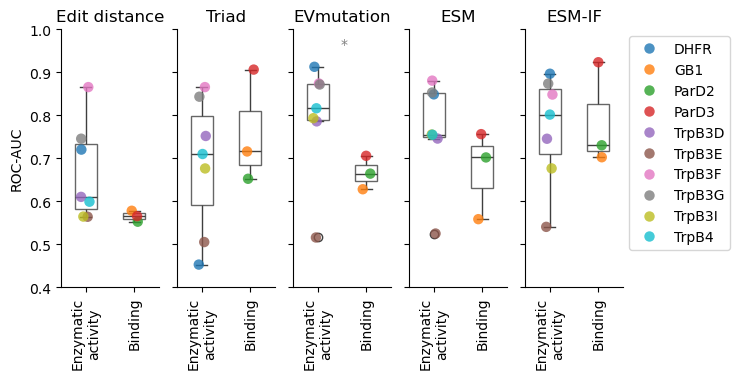

In [30]:
# corr binding vs ea
fig, axes = plt.subplots(1, 5, figsize=(7.2, 3.6), sharey=True)

for z, zs in enumerate(ZS_OPTS):
    ax = axes.flatten()[z]
    x = "all_" + zs.split("_")[0] + "_rocauc"
    bar_type_df = slice_zs[["lib", "type", x]].copy()

    sns.boxplot(
        # x="Type", y="Rho", 
        x="type", y=x, 
        data=bar_type_df, width=0.45, 
        ax=ax,
        # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
        boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
    )
    sns.stripplot(
        # x="Type",
        # y="Rho",
        x="type",
        y=x,
        data=bar_type_df,
        order=bar_type_df['type'].unique()[::-1],
        hue="lib",
        hue_order=bar_type_df['lib'].unique(),
        jitter=True,
        size=7.5,
        # dodge=True,
        palette=sns.color_palette("tab10").as_hex(),
        marker="o",
        alpha=0.8,
        ax=ax
    )

    labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in ax.get_xticklabels()]
    ax.set_xlabel("")
    ax.set_xticklabels( labels, rotation=90, ha="center")
    ax.set_ylim(0.4, 1)
    # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    ax.set_title(ZS_OPTS_LEGEND[x.split("_")[1]+"_score"])
    
    # Hide the top and right spine
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if z != len(ZS_OPTS)-1:
        ax.legend().remove()
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1.0))
    if z == 0:
        ax.set_ylabel("ROC-AUC")
    else:
        ax.set_ylabel("")

    t_val, p_value = ttest_ind(
        list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
        list(bar_type_df[bar_type_df["type"]=="Enzymatic activity"][x]),
        equal_var=False,
    )
    # significance = '*' if p_value < 0.05 else 'ns'  # ns stands for not significant
    # print(f"Comparison of {ms[i]} between {ens_types[p]} and {ens_types[q]} : t={t_val:.3f} and p={p_value:.3f}")

    # Draw a line between points
    p = 0.1
    q = 1
    annot_y = 0.95
    if p_value < 0.05:
        # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
        ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')
    
    # if z == 2:
    #     ax.set_xlabel("ZS type")
    # else:
    #     
    # # plt.title("Triad ZS statistically different for types")
    # plt.ylabel("Type")
    # plt.xlabel(ZS_OPTS_LEGEND[x.split("_")[1]+"_score"] + r"’s fitness prediction Spearman's $\rho$")
    # # plt.legend(title="Group", loc="upper left", bbox_to_anchor=(1, 1.05))
    # plt.legend().remove()
plt.tight_layout(pad=0, h_pad=-.0, w_pad=1.0) 

In [39]:
# corr zs to ft
# need to avg the zs for each rep
# corr 

In [24]:
zs_ft_dict = {}
for ft_metric in ["top_maxes", "if_truemaxs"]:
    zs_ft_dict[ft_metric] = {}
    for zs_metric in ["rho", "rocauc"]:
        zs_ft_dict[ft_metric][zs_metric] = {zs: np.zeros(len(N_SAMPLE_LIST)) for zs in zs_simple}


In [25]:
zs_ft_p_dict = {}
for ft_metric in ["top_maxes", "if_truemaxs"]:
    zs_ft_p_dict[ft_metric] = {}
    for zs_metric in ["rho", "rocauc"]:
        zs_ft_p_dict[ft_metric][zs_metric] = {zs: np.zeros(len(N_SAMPLE_LIST)) for zs in zs_simple}


In [28]:
for i, n in enumerate(N_SAMPLE_LIST):
    merge_df = pd.read_csv(f"results/corr_all/{str(n)}/boosting|ridge-top96/actcut-1/merge_all.csv")

    for ft_metric in ["top_maxes", "if_truemaxs"]:
        
        ft_df = merge_df[[ft_metric+"_"+zs for zs in zs_simple]]
        ft_df.columns = zs_simple

        for zs_metric in ["rho", "rocauc"]:
            for zs in zs_simple:
                if zs == "double":
                    zs_des = "ed"
                else:
                    zs_des = zs
                get_rho, get_p = spearmanr(ft_df[zs], slice_zs["all_"+zs_des+"_"+zs_metric])
                zs_ft_dict[ft_metric][zs_metric][zs][i] = get_rho
                zs_ft_p_dict[ft_metric][zs_metric][zs][i] = get_p

In [29]:
zs_color_list = ["yellow", "orange", "blue", "green", "purple"]

In [30]:
zs_metric_style = {
    "rho": {"marker": "o", "linestyle": "solid"},
    "rocauc": {"marker": "X", "linestyle": "dotted"}
}

In [31]:
zs_metric_style_legend = {
    "rho": r"Spearman's $\rho$",
    "rocauc": "ROC-AUC"
}

In [32]:
ft_metric_title = {
    "top_maxes": "Average max fitenss achieved",
    "if_truemaxs": "Fraction of global optimum achieved"
}

Text(0.5, 0.98, 'ZS ftMLDE Performance Correlation Across 10 Landscapes')

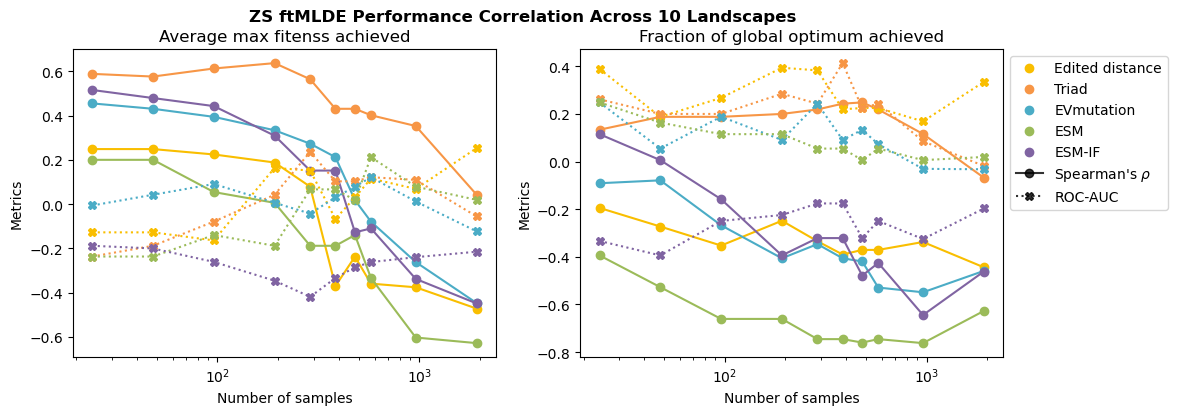

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (ft_metric, v_ft) in enumerate(zs_ft_dict.items()):
    axes[i].set_xscale("log")
    axes[i].set_xlabel("Number of samples")
    axes[i].set_ylabel("Metrics")
    axes[i].set_title(ft_metric_title[ft_metric])

    for zs_metric, v_zs in v_ft.items():
        
        for j, (zs, ys) in enumerate(v_zs.items()):
            axes[i].plot(N_SAMPLE_LIST, ys, label=zs, color=PRESENTATION_PALETTE_SATURATE[zs_color_list[j]], **zs_metric_style[zs_metric])


legend_list = []  # To store legend handles
for zs, lc in zip(zs_simple, zs_color_list):
    if zs == "double":
        l = "Edited distance"
    else:
        l = ZS_OPTS_LEGEND[zs+"_score"]
    legend_list.append(
        Line2D(
            [0],
            [0],
            marker="o",
            linestyle="none",
            color=PRESENTATION_PALETTE_SATURATE[lc],
            label=l,
        )
    )

for m in zs_metric_style.keys():
    legend_list.append(
        Line2D(
            [0],
            [0],
            color="black",
            alpha = 0.8,
            label=zs_metric_style_legend[m],
            **zs_metric_style[m]
        )
    )

axes[1].legend(handles=legend_list, loc="upper left", bbox_to_anchor=(1, 1))

fig.suptitle(
    "ZS ftMLDE Performance Correlation Across 10 Landscapes",
    fontsize=12,
    fontweight="bold",
    # y=0.975,
)

In [34]:
N_SAMPLE_LIST[5]

384

In [35]:
# Initialize a new dictionary to hold the values at index 2 and 5
index_values = {outer_key: {middle_key: {inner_key: zs_ft_dict[outer_key][middle_key][inner_key][[2, 5]]
    for inner_key in zs_ft_dict[outer_key][middle_key]}
    for middle_key in zs_ft_dict[outer_key]}
    for outer_key in zs_ft_dict}


In [36]:
index_values

{'top_maxes': {'rho': {'double': array([ 0.22424242, -0.36969697]),
   'Triad': array([0.61212121, 0.43030303]),
   'ev': array([0.39393939, 0.21212121]),
   'esm': array([ 0.05454545, -0.18787879]),
   'esmif': array([0.44242424, 0.15151515])},
  'rocauc': {'double': array([-0.16363636, -0.06666667]),
   'Triad': array([-0.07878788,  0.1030303 ]),
   'ev': array([0.09090909, 0.03030303]),
   'esm': array([-0.13939394,  0.06666667]),
   'esmif': array([-0.26060606, -0.33333333])}},
 'if_truemaxs': {'rho': {'double': array([-0.35258522, -0.39025116]),
   'Triad': array([0.18787879, 0.24316222]),
   'ev': array([-0.26747844, -0.40606061]),
   'esm': array([-0.66060606, -0.74545455]),
   'esmif': array([-0.15805544, -0.32121212])},
  'rocauc': {'double': array([0.26747844, 0.21951628]),
   'Triad': array([0.2       , 0.41337577]),
   'ev': array([0.18845072, 0.09090909]),
   'esm': array([0.11515152, 0.05454545]),
   'esmif': array([-0.24924127, -0.17575758])}}}

In [50]:
# Create a DataFrame from the dictionary
df_list = []
for marker_type, categories in index_values.items():
    for category, values in categories.items():
        for zs, value in values.items():
            df_list.append({'Metrics': marker_type, 'ZS utilization': category, "ZS predictors": zs, 'Value': value[1]})
df = pd.DataFrame(df_list)
df

,Metrics,ZS utilization,ZS predictors,Value
0,top_maxes,rho,double,-0.369697
1,top_maxes,rho,Triad,0.430303
2,top_maxes,rho,ev,0.212121
3,top_maxes,rho,esm,-0.187879
4,top_maxes,rho,esmif,0.151515
5,top_maxes,rocauc,double,-0.066667
6,top_maxes,rocauc,Triad,0.103030
7,top_maxes,rocauc,ev,0.030303
8,top_maxes,rocauc,esm,0.066667
9,top_maxes,rocauc,esmif,-0.333333


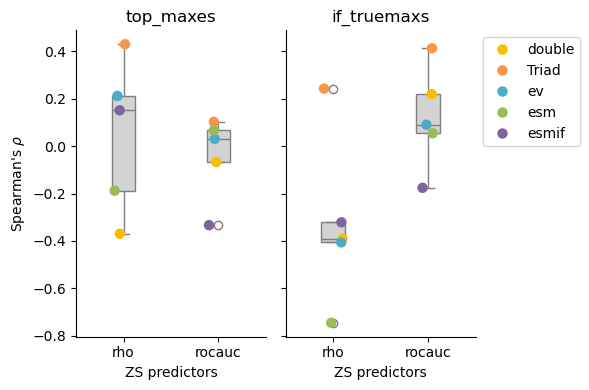

In [47]:
fig, axes = plt.subplots(1,2, figsize=(6, 4), sharey=True)

for m, ax in zip(["top_maxes", "if_truemaxs"], axes):
    sns.boxplot(
        x="ZS utilization", y="Value", data=df[df["Metrics"] == m], ax=ax, width=0.25, 
        color=PRESENTATION_PALETTE_SATURATE["light_gray"],
    )
    ax.set_title(m)
    ax.set_xlabel("ZS predictors")

    sns.stripplot(
        x="ZS utilization", y="Value",
        data=df[df["Metrics"] == m],
        hue="ZS predictors",
        jitter=True,
        size=7.5,
        # dodge=True,
        marker="o",
        # alpha=0.5,
        palette=[PRESENTATION_PALETTE_SATURATE[z] for z in zs_color_list],
        ax=ax
    )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    # labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in plt.gca().get_xticklabels()]
    # ax.set_xticklabels(labels)

#  ax.set_ylabel("Value")
# plt.title("Triad ZS statistically different for types")
# plt.xlabel("Type")
# plt.ylabel(r"Triad's Spearman's $\rho$ with fitness")

axes[0].set_ylabel(r"Spearman's $\rho$")
axes[0].legend_.remove()  # Remove legend from the first subplot
axes[1].legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()


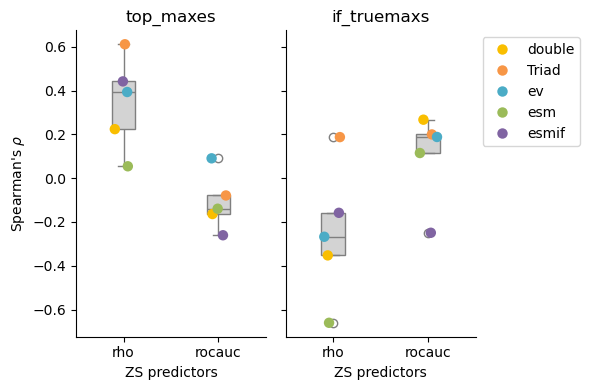

In [51]:
# Create a DataFrame from the dictionary
df_list = []
for marker_type, categories in index_values.items():
    for category, values in categories.items():
        for zs, value in values.items():
            df_list.append({'Metrics': marker_type, 'ZS utilization': category, "ZS predictors": zs, 'Value': value[0]})
df = pd.DataFrame(df_list)

fig, axes = plt.subplots(1,2, figsize=(6, 4), sharey=True)

for m, ax in zip(["top_maxes", "if_truemaxs"], axes):
    sns.boxplot(
        x="ZS utilization", y="Value", data=df[df["Metrics"] == m], ax=ax, width=0.25, 
        color=PRESENTATION_PALETTE_SATURATE["light_gray"],
    )
    ax.set_title(m)
    ax.set_xlabel("ZS predictors")

    sns.stripplot(
        x="ZS utilization", y="Value",
        data=df[df["Metrics"] == m],
        hue="ZS predictors",
        jitter=True,
        size=7.5,
        # dodge=True,
        marker="o",
        # alpha=0.5,
        palette=[PRESENTATION_PALETTE_SATURATE[z] for z in zs_color_list],
        ax=ax
    )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    # labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in plt.gca().get_xticklabels()]
    # ax.set_xticklabels(labels)

#  ax.set_ylabel("Value")
# plt.title("Triad ZS statistically different for types")
# plt.xlabel("Type")
# plt.ylabel(r"Triad's Spearman's $\rho$ with fitness")

axes[0].set_ylabel(r"Spearman's $\rho$")
axes[0].legend_.remove()  # Remove legend from the first subplot
axes[1].legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
